In [1]:
from typing import Annotated, TypedDict,Sequence, Literal, Optional
from langgraph.graph import add_messages
from dotenv import load_dotenv
import os
from openai import OpenAI
from langgraph.prebuilt import ToolNode
from langchain_core.tools import tool
from langchain_core.messages import BaseMessage, SystemMessage, ToolMessage
from langgraph.graph import StateGraph, START, END

<img src="https://github.com/dv-learn/langgraph-journey-sam/blob/main/images/Episode1_Sam_Arrives_To_Village.jpg?raw=true" alt="Image of LLM node acted by Librarian!"/>




<img src="https://github.com/dv-learn/langgraph-journey-sam/blob/main/images/Episode2_Greeter_to_Library_LLMNode.jpg?raw=true"/>

In [2]:
# environment

load_dotenv(override=True)
os.environ['OPENAI_API_KEY'] = os.getenv('OPENAI_API_KEY', 'your-key-if-not-using-env')
os.environ['ANTHROPIC_API_KEY'] = os.getenv('ANTHROPIC_API_KEY', 'your-key-if-not-using-env')
os.environ['HF_TOKEN'] = os.getenv('HF_TOKEN', 'your-key-if-not-using-env')

In [3]:
from typing import TypedDict, Optional

# This schema tracks all messages exchanged among nodes, — like a running conversation log.
class SamState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]


In [4]:
def greeting_node(state: SamState)-> SamState:
    """ This node responds with a friendly greeting and some guidance for anyone in village"""

    greeting_message = """
Welcome to Harmonyville, traveler!
I’m the village greeter — here to help you find your way. If you're new, here's how things work around here:

If you’re unsure what to do or need guidance, speak with our kind **Librarian**. She’s wise and always ready to help.

Curious about the weather before planning something big? Our **Weather Station** expert has the latest forecast!

Need approval for an event or announcement? Our cheerful **Mayor** will give you the green (or red) signal.

Just ask your question, and our town will work together to help you out.

Let’s begin your journey — what would you like to do today?
"""
    print(f"🧑‍🏫 Assistant:{greeting_message}")  
    return {
        "messages": [AIMessage(content=greeting_message)]
    }

In [5]:
def user_input_node(state: SamState) -> SamState:
    """ This is the node, to hear input from end user based on the reply from greeter node.
    This node simply takes input from user , updated the state."""
    user_input = input("\n👤 Sam Wants: ")
    return {
        "messages":  [HumanMessage(content=user_input)]
    }

In [6]:
def router_node(state: SamState) -> SamState:
    """ This is router node acts as conditional logic to route to library or LLM node if needs help,
    other wise route to end logic"""
    
    # Fetching the last message, from the state variable,
    user_input = state["messages"][-1].content.lower()
     
    #print(user_input)
    if "plan" in user_input or "event" in user_input or "help" in user_input:
        return "library"
    else:
        return "end"

In [7]:
from langchain_openai import ChatOpenAI
def library_node(state: SamState) -> SamState:
    """This node acts like librarian and full of wisdom and guides people having problem with solution
    based on knowledge she has acquired with the ages of data and reading."""
    
    model = ChatOpenAI(model = "gpt-4o-mini")
    
    system_prompt = 
    (content=
        "You are wise librarian in this small village, all people come to you for their solution.\
    you guide people with your wisdom and knowledge you gained from life long data, books and knowledge. \
    Let me give you more info on the village, here apart from people, there are community helpers like \
    weather station person who predicts weather with his tools and finally mayor who has final authority to \
    approve and announce decisions of village."
    )
    result = model.invoke([system_prompt] + state["messages"])
    print(f"🧑‍🏫 Assistant: {result.content}")
    
    return {
        "messages":  [AIMessage(content=result.content)]
    }

In [8]:
# We add our greeting node and make it the starting point of our graph.
graph = StateGraph(SamState)
graph.add_node("greeting", greeting_node)
graph.add_node("user_input", user_input_node)
graph.add_node("router", lambda x: x)
graph.add_node("library", library_node)
graph.set_entry_point("greeting")
graph.add_edge("greeting", "user_input")
graph.add_edge("user_input", "router")
graph.add_conditional_edges(
    "router", 
    router_node, 
    {
        "library":"library",
        "end": END
    })
graph.add_edge("library",END)


app = graph.compile()



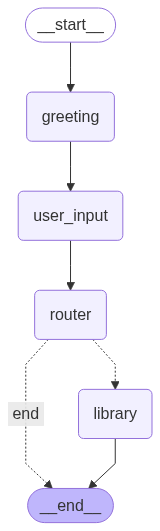

In [9]:
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

In [10]:
from langchain_core.messages import HumanMessage, AIMessage


# Start with Sam’s first message
user_input = input("\n👤 Sam: ")
messages = [HumanMessage(content=user_input)]


# 🔁 Invoke LangGraph app with current conversation
state = app.invoke({"messages": messages})




👤 Sam:  HI I AM NEW HERE..


🧑‍🏫 Assistant:
Welcome to Harmonyville, traveler!
I’m the village greeter — here to help you find your way. If you're new, here's how things work around here:

If you’re unsure what to do or need guidance, speak with our kind **Librarian**. She’s wise and always ready to help.

Curious about the weather before planning something big? Our **Weather Station** expert has the latest forecast!

Need approval for an event or announcement? Our cheerful **Mayor** will give you the green (or red) signal.

Just ask your question, and our town will work together to help you out.

Let’s begin your journey — what would you like to do today?




👤 Sam Wants:  I want to host event this weekend.


🧑‍🏫 Assistant: That sounds like a wonderful idea! Hosting an event can bring the community together and create lasting memories. Here are the steps you can take to organize your event this weekend:

1. **Decide on the Details**: 
   - What type of event do you want to host? (e.g., a picnic, a market, a workshop)
   - What time and location do you have in mind?
   - How many people do you expect to attend?

2. **Check with the Mayor**: 
   - Since the Mayor has the final authority to approve events, it’s essential to present your plans to them. Prepare a brief description of your event, including the date, time, location, and any special requirements you might have.

3. **Gather Community Helpers**: 
   - If you need assistance, consider reaching out to community helpers like the Weather Station person to check the forecast for the weekend. It’s always good to prepare for any unexpected weather changes.

4. **Promote Your Event**: 
   - Once you have approval, spread the word! You can u